In [36]:

num_clients = 30
distribution_type = 'random_iid'  # Can also be 'random' for non-IID distribution
root_percentage = 0.2  # Define the percentage of the dataset to use for the root client


# Split into Dist

In [37]:
import os
import struct
import numpy as np

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`."""
    labels_path = os.path.join(path, f'{kind}-labels.idx1-ubyte')
    images_path = os.path.join(path, f'{kind}-images.idx3-ubyte')

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

# Path to the directory containing the ubyte files
mnist_path = 'mnist'

# Load training and test data
x_train, y_train = load_mnist(mnist_path, kind='train')
x_test, y_test = load_mnist(mnist_path, kind='t10k')

# Optionally, split the training data into training and validation sets
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=10000, random_state=42)

# Reshape images to 28x28 if necessary
x_train = x_train.reshape(-1, 28, 28, 1)
x_valid = x_valid.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

print("Training data:", x_train.shape, y_train.shape)
print("Validation data:", x_valid.shape, y_valid.shape)
print("Test data:", x_test.shape, y_test.shape)

Training data: (50000, 28, 28, 1) (50000,)
Validation data: (10000, 28, 28, 1) (10000,)
Test data: (10000, 28, 28, 1) (10000,)


New

Client 1 data saved: dataset/client_1/x_data.npy, dataset/client_1/y_data.npy
Client 2 data saved: dataset/client_2/x_data.npy, dataset/client_2/y_data.npy
Client 3 data saved: dataset/client_3/x_data.npy, dataset/client_3/y_data.npy
Client 4 data saved: dataset/client_4/x_data.npy, dataset/client_4/y_data.npy
Client 5 data saved: dataset/client_5/x_data.npy, dataset/client_5/y_data.npy
Client 6 data saved: dataset/client_6/x_data.npy, dataset/client_6/y_data.npy
Client 7 data saved: dataset/client_7/x_data.npy, dataset/client_7/y_data.npy
Client 8 data saved: dataset/client_8/x_data.npy, dataset/client_8/y_data.npy
Client 9 data saved: dataset/client_9/x_data.npy, dataset/client_9/y_data.npy
Client 10 data saved: dataset/client_10/x_data.npy, dataset/client_10/y_data.npy
Client 11 data saved: dataset/client_11/x_data.npy, dataset/client_11/y_data.npy
Client 12 data saved: dataset/client_12/x_data.npy, dataset/client_12/y_data.npy
Client 13 data saved: dataset/client_13/x_data.npy, dat

/var/folders/k8/v02rcpmj2bv13wz_w7qm_tdh0000gn/T/ipykernel_29726/2371467436.py:178: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')  # Use 'tab10' colormap for up to 10 distinct colors
/var/folders/k8/v02rcpmj2bv13wz_w7qm_tdh0000gn/T/ipykernel_29726/2371467436.py:178: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')  # Use 'tab10' colormap for up to 10 distinct colors


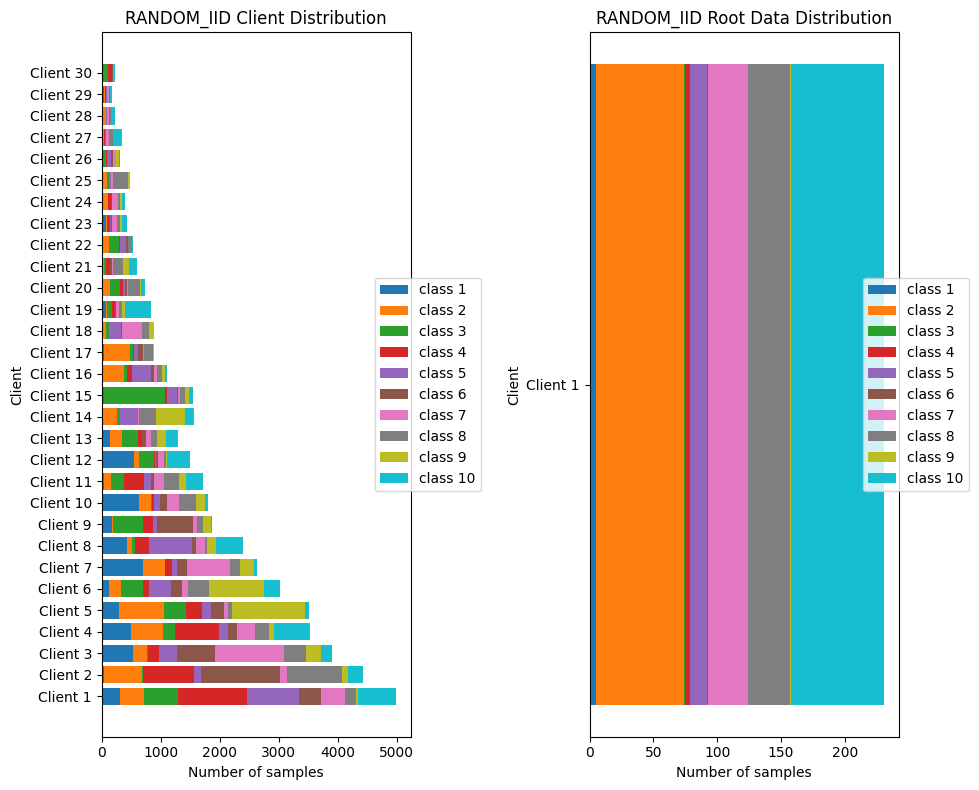

In [42]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt

import os
import numpy as np
import random
import matplotlib.pyplot as plt

import os
import numpy as np

class FederatedDataSplitter:
    def __init__(self, x_train, y_train, x_test, y_test, num_clients=10, distribution='iid', root_size=0.2, dataset_dir='dataset', root_client=False):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.num_clients = num_clients
        self.distribution = distribution
        self.root_size = root_size
        self.dataset_dir = dataset_dir
        self.root_client = root_client
        self.client_distributions = []
        self.root_distribution = []

    def split_data(self, root_client=False):
        # Ensure the dataset directory exists
        os.makedirs(self.dataset_dir, exist_ok=True)
        root_client = self.root_client

        # Initialize the full training set as available for clients
        x_train_clients = self.x_train
        y_train_clients = self.y_train

        client_data = []

        # Split remaining data across clients
        if self.distribution == 'iid':
            # For IID distribution, split the data equally among clients
            split_sizes = [len(x_train_clients) // self.num_clients] * self.num_clients
            if sum(split_sizes) != len(x_train_clients):
                split_sizes[-1] += len(x_train_clients) - sum(split_sizes)

            start_idx = 0
            for i in range(self.num_clients):
                end_idx = start_idx + split_sizes[i]
                x_client = x_train_clients[start_idx:end_idx]
                y_client = y_train_clients[start_idx:end_idx]
                start_idx = end_idx

                client_data.append((x_client, y_client))

                # Save client data
                self.save_client_data(x_client, y_client, client_id=i+1)

                # Track class distribution for each client
                client_distribution = np.bincount(y_client, minlength=10)
                self.client_distributions.append(client_distribution)

        elif self.distribution == 'random_iid':
            # For random_iid with class imbalance
            class_data = {}

            # Create class-wise splits
            for class_label in range(10):
                class_indices = np.where(y_train_clients == class_label)[0]
                class_data[class_label] = (x_train_clients[class_indices], y_train_clients[class_indices])

            # Assign each client a random proportion of samples from each class
            for i in range(self.num_clients):
                x_client = []
                y_client = []

                # Assign random proportions of each class to the client
                class_proportions = np.random.dirichlet(np.ones(10))  # Random distribution over classes

                for class_label in range(10):
                    x_class, y_class = class_data[class_label]
                    class_size = int(len(x_class) * class_proportions[class_label])  # Get proportional size

                    # Randomly select samples from the class data
                    chosen_indices = np.random.choice(len(x_class), class_size, replace=False)
                    x_client.append(x_class[chosen_indices])
                    y_client.append(y_class[chosen_indices])

                    # Remove selected samples from the available pool
                    class_data[class_label] = (np.delete(x_class, chosen_indices, axis=0), 
                                            np.delete(y_class, chosen_indices, axis=0))

                # Concatenate the client's samples across all classes
                x_client = np.concatenate(x_client)
                y_client = np.concatenate(y_client)

                client_data.append((x_client, y_client))

                # Save client data
                self.save_client_data(x_client, y_client, client_id=i+1)

                # Track class distribution for each client
                client_distribution = np.bincount(y_client, minlength=10)
                self.client_distributions.append(client_distribution)

        # If root_client is True, assign one client's data to the root
        if root_client:
            random_client_id = np.random.randint(0, self.num_clients)
            x_root, y_root = client_data[random_client_id]
            print(f"Assigning Client {random_client_id+1}'s data to root")

            # Save root data
            self.save_root_data(x_root, y_root)
            self.root_distribution = np.bincount(y_root, minlength=10)

            print(f"Total samples in root: {len(x_root)}, Samples per class: {np.bincount(y_root)}")
            

        # Save test data
        self.save_test_data()


    def save_client_data(self, x_client, y_client, client_id):
        # Create directories for each client
        client_dir = os.path.join(self.dataset_dir, f'client_{client_id}')
        os.makedirs(client_dir, exist_ok=True)

        # Save data as numpy files
        np.save(os.path.join(client_dir, 'x_data.npy'), x_client)
        np.save(os.path.join(client_dir, 'y_data.npy'), y_client)

        print(f"Client {client_id} data saved: {client_dir}/x_data.npy, {client_dir}/y_data.npy")

    def save_test_data(self):
        # Save test data in a separate directory
        test_dir = os.path.join(self.dataset_dir, 'test')
        os.makedirs(test_dir, exist_ok=True)

        np.save(os.path.join(test_dir, 'x_test.npy'), self.x_test)
        np.save(os.path.join(test_dir, 'y_test.npy'), self.y_test)

        print(f"Test data saved: {test_dir}/x_test.npy, {test_dir}/y_test.npy")

    def save_root_data(self, x_root, y_root):
        # Save root data in a separate directory
        root_dir = os.path.join(self.dataset_dir, 'root')
        os.makedirs(root_dir, exist_ok=True)

        np.save(os.path.join(root_dir, 'x_data.npy'), x_root)
        np.save(os.path.join(root_dir, 'y_data.npy'), y_root)

        print(f"Root data saved: {root_dir}/x_data.npy, {root_dir}/y_data.npy")
        print(f"Total samples in root: {len(x_root)}, Samples per class: {np.bincount(y_root)}")



    @staticmethod
    def plot_distributions(client_dist, root_dist, num_clients, title, root_client=False, root_assigned_client=None):
        """Plot the class distributions of clients and the root data."""
        plt.figure(figsize=(10, 8))

        # Plot client distribution
        plt.subplot(1, 2, 1)
        FederatedDataSplitter.plot_sample_stats(client_dist, num_clients, root_client=root_client, root_assigned_client=root_assigned_client)
        plt.title(f'{title} Client Distribution')

        # Plot root client distribution if not assigned to a client
        if not root_client:
            plt.subplot(1, 2, 2)
            FederatedDataSplitter.plot_sample_stats([root_dist], 1)
            plt.title(f'{title} Root Data Distribution')

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_sample_stats(dist, num_clients, root_client=False, root_assigned_client=None):
        """Plot the sample statistics for each client."""
        colors = plt.cm.get_cmap('tab10')  # Use 'tab10' colormap for up to 10 distinct colors

        # If it's a single client (for root data)
        if num_clients == 1:
            classes = [f'class {i+1}' for i in range(len(dist[0]))]
            left = 0

            # Plot each class with a different color
            for i in range(len(classes)):
                plt.barh(0, dist[0][i], left=left, color=colors(i), label=classes[i])
                left += dist[0][i]  # Accumulate values to stack bars properly

        else:
            # For multiple clients, plot the distribution across clients
            classes = [f'class {i+1}' for i in range(len(dist[0]))]
            left = np.zeros(num_clients)  # Initialize left with zeros for clients

            # Plot each class with the same color scheme
            for i in range(len(classes)):
                plt.barh(range(num_clients), [dist[j][i] for j in range(num_clients)],
                         left=left, color=colors(i), label=classes[i])
                left += [dist[j][i] for j in range(num_clients)]  # Accumulate values to stack bars properly

            # Highlight the client assigned root data if applicable
            if root_client and root_assigned_client is not None:
                plt.barh(root_assigned_client - 1, sum(dist[root_assigned_client - 1]), color='red', alpha=0.3, label="Root Client")

        # Add legend and labels
        plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
        plt.yticks(range(num_clients), [f'Client {i+1}' for i in range(num_clients)])
        plt.xlabel('Number of samples')
        plt.ylabel('Client')


splitter = FederatedDataSplitter(x_train, y_train, x_test, y_test,
                                num_clients=num_clients, 
                                root_size=root_percentage, 
                                dataset_dir='dataset',
                                distribution=distribution_type,
                                root_client=True)

splitter.split_data()

# Plot the distributions
splitter.plot_distributions(splitter.client_distributions, splitter.root_distribution, splitter.num_clients, splitter.distribution.upper())


In [23]:
import numpy as np

def normalize_matrix_fp16(matrix):
    """
    Normalize a NumPy matrix to values between 0 and 1 using FP16 precision.

    Parameters:
    matrix (np.ndarray): The input matrix to normalize.

    Returns:
    np.ndarray: The normalized matrix with values between 0 and 1 in float16 precision, rounded to 3 decimals.
    """
    # Ensure the input is a NumPy array
    matrix = np.array(matrix, dtype=np.float32)  # Use float32 for calculations
    
    # Calculate the minimum and maximum values of the matrix
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    
    # Avoid division by zero if all elements are the same
    if max_val > min_val:
        normalized_matrix = (matrix - min_val) / (max_val - min_val)
    else:
        normalized_matrix = np.zeros_like(matrix)  # Return zero matrix if min == max

    # Convert to float16 for reduced precision
    normalized_matrix = normalized_matrix.astype(np.float16)
    
    # Round to 3 decimal places
    rounded_matrix = np.round(normalized_matrix, 3)
    
    return rounded_matrix


# Example usage
if __name__ == "__main__":
    sample_matrix = np.array([[1.00020206, 0.99929529, 0.99930912, 1.00020099, 0.99932802],
 [1.00063419, 1.00056005, 1.00052989, 1.00063038, 1.00052178]])

    normalized_fp16 = normalize_matrix_fp16(sample_matrix)
    print("Original Matrix:")
    print(sample_matrix)
    print("Normalized Matrix (FP16):")
    print(normalized_fp16)


Original Matrix:
[[1.00020206 0.99929529 0.99930912 1.00020099 0.99932802]
 [1.00063419 1.00056005 1.00052989 1.00063038 1.00052178]]
Normalized Matrix (FP16):
[[0.677 0.    0.01  0.676 0.024]
 [1.    0.945 0.922 0.997 0.916]]


In [24]:
sample_matrix = np.array([[0.9991591,  0.99913645, 0.99943489, 0.99939746, 0.99913621],
 [0.99922186, 0.99923229, 0.99974221, 0.99974126, 0.99922407]])

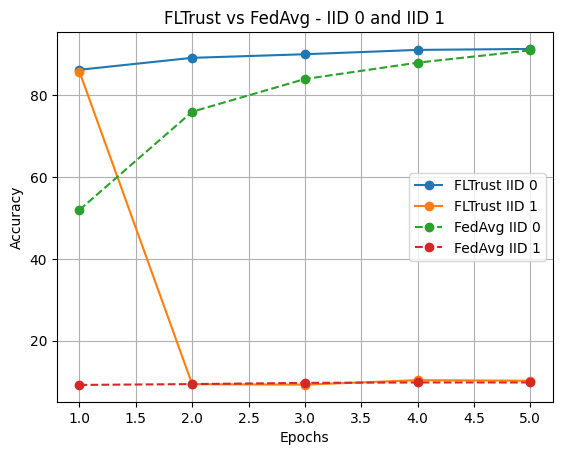

In [25]:
import matplotlib.pyplot as plt

# Data for FLTrust and FedAvg
epochs = [1, 2, 3, 4, 5]

fltrust_iid_0 = [86.26, 89.18, 90.06, 91.12, 91.36]
fltrust_iid_1 = [85.82, 9.38, 9.26, 10.36, 10.22]

fedavg_iid_0 = [52, 76, 84, 88, 91]
fedavg_iid_1 = [9.2, 9.4, 9.7, 9.8, 9.8]

# Plot FLTrust results
plt.plot(epochs, fltrust_iid_0, label="FLTrust IID 0", marker='o')
plt.plot(epochs, fltrust_iid_1, label="FLTrust IID 1", marker='o')

# Plot FedAvg results with dotted lines
plt.plot(epochs, fedavg_iid_0, label="FedAvg IID 0", linestyle='--', marker='o')
plt.plot(epochs, fedavg_iid_1, label="FedAvg IID 1", linestyle='--', marker='o')

# Labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('FLTrust vs FedAvg - IID 0 and IID 1')

# Legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()
